In [16]:
import matplotlib 
import matplotlib.pyplot as plt
import glob
import json
import pickle
import ternary
#import dm_tools
import numpy as np
import seaborn as sns
from scipy import stats
sns.set(style="ticks")
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chisquare
from matplotlib import rcParams
from scipy.interpolate import griddata
import math
import matplotlib.cm as cm
import matplotlib.animation as animation

%matplotlib inline



print('Done')

Done


In [17]:
#Heat map generation

def make_plot(c,eh,ax,fig,npts=100):
  x=c[0,:]
  y=c[1,:]
  X,Y=np.meshgrid(np.linspace(x.min(),x.max(),npts),
                  np.linspace(y.min(),y.max(),npts) ) 
  eH=griddata((x,y),eh,(X,Y),method='linear',fill_value=np.mean(eh))
  CM=ax.imshow(np.flipud(eH),cmap=cm.RdYlGn,
            extent=[x.min(),x.max(),y.min(),y.max()],
            interpolation='bicubic')
  fig.colorbar(CM)
  ax.set_xlabel(r'$x$', fontsize=fs+10)
  ax.set_ylabel(r'$y$', fontsize=fs+10)
  return CM

print('Done')

Done


Conditions discontinuous in lower left-hand corner
Conditions discontinuous in lower right-hand corner
Conditions discontinuous in upper left-hand corner
Conditions discontinuous in upper right-hand corner
Done


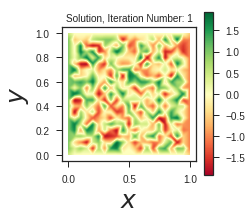

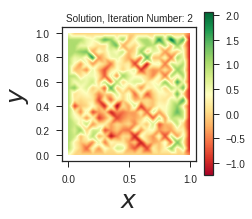

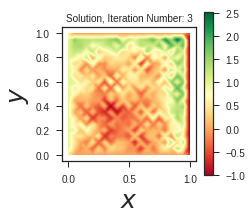

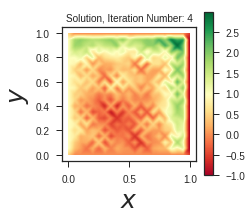

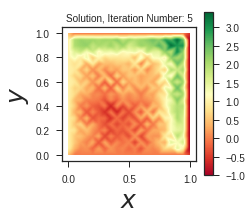

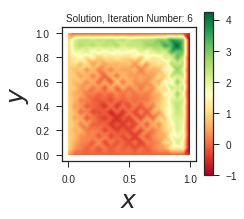

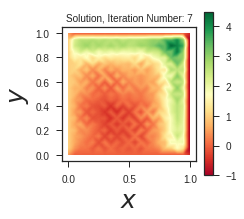

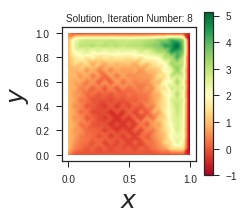

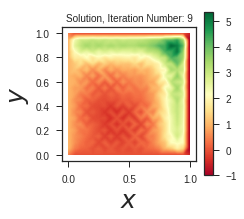

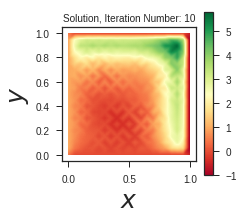

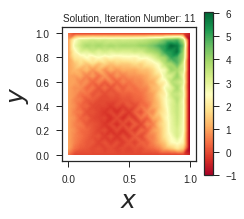

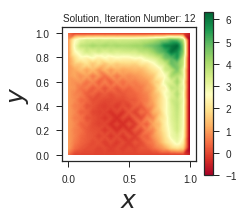

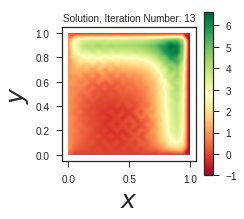

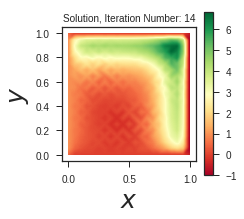

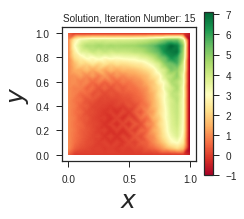

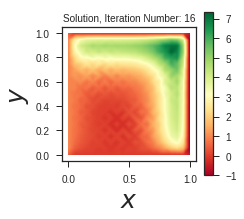

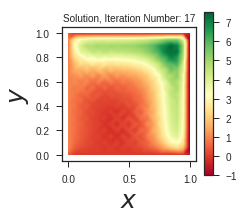

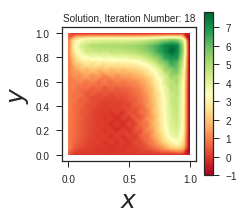

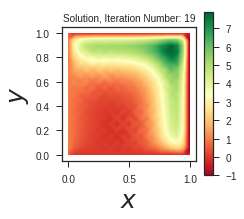

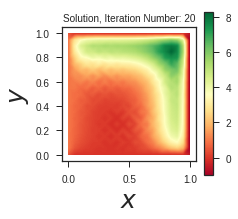

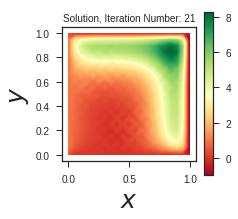

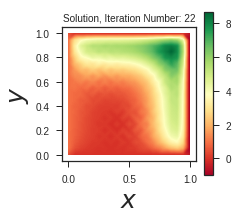

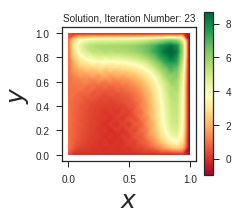

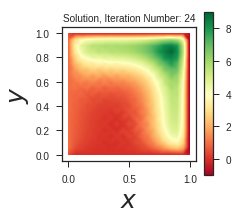

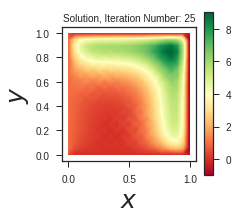

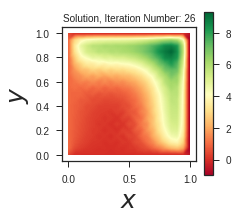

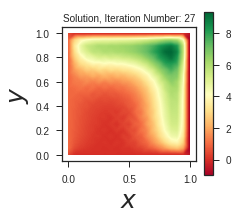

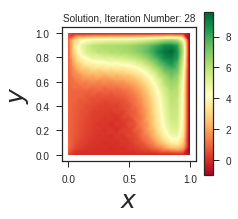

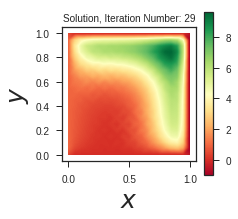

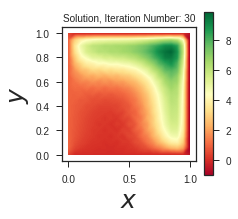

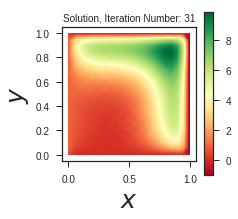

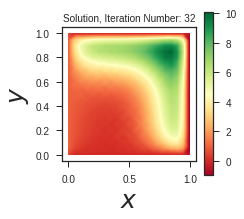

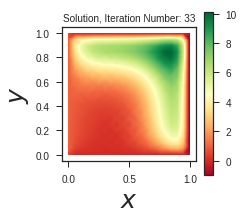

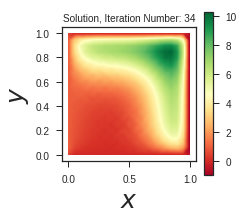

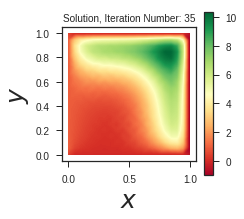

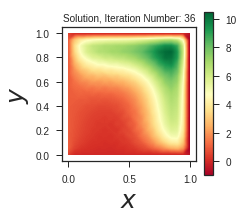

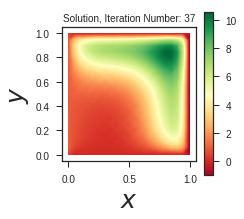

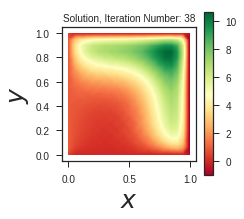

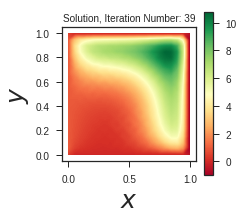

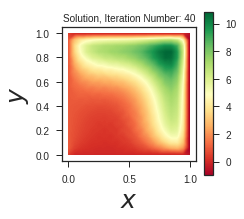

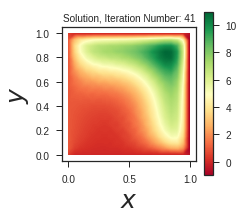

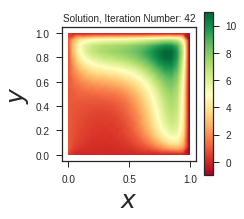

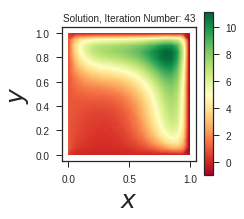

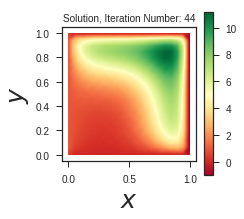

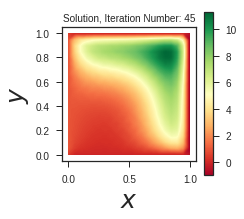

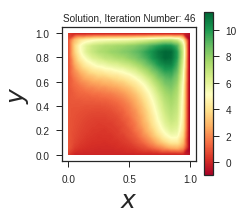

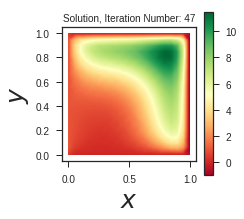

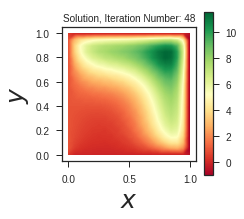

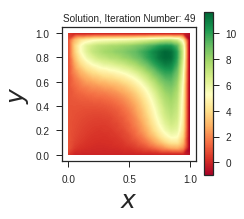

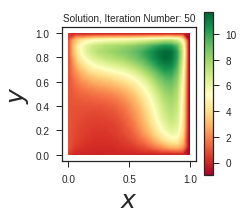

In [48]:
#Perform relaxation method to solve Poisson's equation in 2D

##############################################################################################

#Produce arrays that described the fixed boundary conditions along each edge of the grid
def lx0_boundary(L, h):
    bound=[]
    for k in range(0,L+1):
        x=k*h
#        value=-x**2 #This is where you type in the function that defines the boundary for the left-hand x-axis
        value=+1
        bound.append(value)
    return bound
    
def lx1_boundary(L, h):
    bound=[]
    for k in range(0,L+1):
        x=k*h
#        value=-(1-x)**2 #This is where you type in the function that defines the boundary for the right-hand x-axis
        value=-1
        bound.append(value)
    return bound

def ly0_boundary(L, h):
    bound=[]
    for k in range(0,L+1):
        x=k*h
#        value=-x**2 #This is where you type in the function that defines the boundary for the lower y-axis
        value=0
        bound.append(value)
    return bound

def ly1_boundary(L, h):
    bound=[]
    for k in range(0,L+1):
        x=k*h
#        value=-(1-x)**2 #This is where you type in the function that defines the boundary for the upper y-axis
        value=0
        bound.append(value)
    return bound

#############################################################################################

#Compute the source function over the integration region
def source_function(region, h):
  L=len(region[0])
  sigma=1
  source_region=np.zeros((L,L))
  for k in range(0, L):
    y=k*h
    for l in range(0, L):
        x=l*h
#        f=-10*np.exp((-(x-0.5)**2-(y-0.5)**2)/(2*sigma**2))   #This line defines the source function
#        f=0   #Setting f=0 means you're solving the Laplace equation
#        f=100*y
#        f=0.1*(np.exp(10*y)-1)
        f=0.1*(np.exp(10*y)+np.exp(10*x))
    
        source_region[k][l]=-1*f
  return source_region
        
############################################################################################
    
#Function to generate the NxN region that is to be relaxed, including the boundary conditions along the edges
def region_generator(l0, l1, l2, l3, h):
  L=len(l0)
  region=np.zeros((L,L))
  for k in range(0,L):
    for l in range(0,L):
        region[k][l]=np.random.uniform(-2.0,2.0)
#        region[k][l]=0
  c00=0.5*(l0[0]+l2[0])     #Lower left-hand corner
  c01=0.5*(l1[0]+l2[L-1])   #Lower right-hand corner
  c10=0.5*(l0[L-1]+l3[0])   #Upper left-hand corner
  c11=0.5*(l1[L-1]+l3[L-1]) #Upper right-hand corner

  if l0[0]==l2[0]:
        print('Conditions continuous in lower left-hand corner.')
  else:
        print('Conditions discontinuous in lower left-hand corner')
        
  if l1[0]==l2[L-1]:
        print('Conditions continuous in lower right-hand corner.')
  else:
        print('Conditions discontinuous in lower right-hand corner')
        
  if l0[L-1]==l3[0]:
        print('Conditions continuous in upper left-hand corner.')
  else:
        print('Conditions discontinuous in upper left-hand corner')
        
  if l1[L-1]==l3[L-1]:
        print('Conditions continuous in upper right-hand corner.')
  else:
        print('Conditions discontinuous in upper right-hand corner')
        
        
  region[0]=l2
  region[L-1]=l3
  for i in range(0,L):
    region[i][0]=l0[i]
    region[i][L-1]=l1[i]
    
  region[0][0]=c00      #Write-in the corners of the grid by hand
  region[0][L-1]=c01
  region[L-1][0]=c10
  region[L-1][L-1]=c11
  return region

#######################################################################################

#Function to perform a single relaxation iteration on the grid
def relax_grid(region, source, h):
    L=len(region)
    
    new_region=np.zeros((L,L))
    
    new_region[0]=region[0]
    new_region[L-1]=region[L-1]
    
    for i in range(0,L):
      new_region[i][0]=region[i][0]
      new_region[i][L-1]=region[i][L-1]

    
    for k in range(1,L-1):
        for l in range(1,L-1):
            new_region[k][l]=0.25*(region[k][l+1]+region[k+1][l]+region[k][l-1]+region[k-1][l]-(h**2)*source[k][l])
    
    return new_region

######################################################################################

#Set-up the grid over which the relaxation will be performed

h=0.05      #Define step size

ylim=1      #Upper y-axis limit for the integration region
xlim=ylim   #Right x-axis limit for the integration region

N = np.int(ylim/h)  #Calculate number of grid points
    
lx0 = lx0_boundary(N, h)    #Left-hand x-axis boundary condition
lx1 = lx1_boundary(N, h)    #Right-hand x-axis boundary condition
ly0 = ly0_boundary(N, h)    #Lower y-axis boundary condition
ly1 = ly1_boundary(N, h)    #Upper y-axis boundary condition

region=region_generator(lx0, lx1, ly0, ly1, h)

N=len(region[0])
fs=15
shift=0.05

step_num=50   #Number of relaxation iterations

source=source_function(region, h)

##################################################################################################

#Perform the loop that does the relaxation iteration steps
for k in range(10, step_num+10):

  grid_holder={'x':[], 'y':[], 'solution':[], 'source':[]}
  for i in range(0,N):
    for j in range(0,N):
      grid_holder['x'].append(j*h)
      grid_holder['y'].append(i*h)
      grid_holder['solution'].append(region[i][j])
      grid_holder['source'].append(source[i][j])
  panda_grid=pd.DataFrame(grid_holder)


  plt.figure(figsize=(3,3))
  fig=plt.figure(figsize=(3,3))
  ax=plt.gca()
  slice=make_plot(np.array([panda_grid['x'].values,
                    panda_grid['y'].values]),
                    panda_grid['solution'],ax,fig)
  ax.set_xlim([0-shift,xlim+shift])
  ax.set_ylim([0-shift,ylim+shift])
#  ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
#  ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1])
  ax.set_title('Solution, Iteration Number: '+np.str(k-9), fontsize=fs-5)
  plt.savefig('relaxation_iteration_'+np.str(k)+'.png')

  region=relax_grid(region, source, h)
    
############################################################################################
  

print('Done')